# Libraries 
The most important libraries needed for this project

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

# Loading the data
We will now load the csv comics data into the dataframe and take a quick look at the columns and data being transferred

In [2]:
df_comics = pd.read_csv('../input/marvel-comic-books/Marvel_Comics.csv')
df_comics.head()

,comic_name,active_years,issue_title,publish_date,issue_description,penciler,writer,cover_artist,Imprint,Format,Rating,Price
0,A Year of Marvels: April Infinite Comic (2016),(2016),A Year of Marvels: April Infinite Comic (2016) #1,"April 01, 2016",The Infinite Comic that will have everyone tal...,Yves Bigerel,Yves Bigerel,Jamal Campbell,Marvel Universe,Infinite Comic,Rated T+,Free
1,A Year of Marvels: August Infinite Comic (2016),(2016),A Year of Marvels: August Infinite Comic (2016...,"August 10, 2016","It’s August, and Nick Fury is just in time to ...",Jamal Campbell,"Chris Sims, Chad Bowers",None,Marvel Universe,Infinite Comic,None,Free
2,A Year of Marvels: February Infinite Comic (2016),(2016),A Year of Marvels: February Infinite Comic (20...,"February 10, 2016",Join us in a brand new Marvel comics adventure...,"Danilo S. Beyruth, M Mast",Ryan North,None,Marvel Universe,Infinite Comic,Rated T+,Free
3,A Year of Marvels: July Infinite Comic (2016),(2016),A Year of Marvels: July Infinite Comic (2016) #1,"June 29, 2016",Celebrating the Fourth of July is complicated ...,Juanan Ramirez,Chuck Wendig,Jamal Campbell,Marvel Universe,Infinite Comic,None,Free
4,A Year of Marvels: June Infinite Comic (2016),(2016),A Year of Marvels: June Infinite Comic (2016) #1,"June 15, 2016",Sam Alexander’s finding it hard to cope with t...,Diego Olortegui,Paul Allor,Jamal Campbell,Marvel Universe,Infinite Comic,None,Free


# Cleaning and preprocessing of our data
Data preprocessing is one of the most important steps in text analytics. The goal is to remove any unwanted words or characters that serve human readability, but will not contribute to better results for our model.

The following function uses regular expressions to match patterns of unwanted text and remove/replace them.

In [3]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#creating a list of punctuation and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#Function to clean and process data

def spacy_tokenizer(sentence):
 
    #removal of unnecessary single quotation marks
    sentence = re.sub('\'','',sentence)

    #removal of digits and words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replacing redundant spaces with single spaces
    sentence = re.sub(' +',' ',sentence)

    #removal of unnecessary lines beginning with special characters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #removal of non-breaking signs
    sentence = re.sub(r'\n',' ',sentence)
    
    #removing punctuation
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creation of token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatization
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords and skip words shorter than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return of tokens
    return tokens

Function of cleansing and preprocessing data for comics in "issue_description" column. We will save the cleansed and tokenized data in a new column.

In [4]:
print('Cleaning and Tokenizing...')
%time df_comics['issue_description_tokenized'] = df_comics['issue_description'].map(lambda x: spacy_tokenizer(x))
df_comics.head()

Cleaning and Tokenizing...
CPU times: user 7min 30s, sys: 404 ms, total: 7min 31s
Wall time: 7min 31s


,comic_name,active_years,issue_title,publish_date,issue_description,penciler,writer,cover_artist,Imprint,Format,Rating,Price,issue_description_tokenized
0,A Year of Marvels: April Infinite Comic (2016),(2016),A Year of Marvels: April Infinite Comic (2016) #1,"April 01, 2016",The Infinite Comic that will have everyone tal...,Yves Bigerel,Yves Bigerel,Jamal Campbell,Marvel Universe,Infinite Comic,Rated T+,Free,"[infinite, comic, talk, fun, heart, prank, fol..."
1,A Year of Marvels: August Infinite Comic (2016),(2016),A Year of Marvels: August Infinite Comic (2016...,"August 10, 2016","It’s August, and Nick Fury is just in time to ...",Jamal Campbell,"Chris Sims, Chad Bowers",None,Marvel Universe,Infinite Comic,None,Free,"[august, nick, fury, time, attend, japan, bon,..."
2,A Year of Marvels: February Infinite Comic (2016),(2016),A Year of Marvels: February Infinite Comic (20...,"February 10, 2016",Join us in a brand new Marvel comics adventure...,"Danilo S. Beyruth, M Mast",Ryan North,None,Marvel Universe,Infinite Comic,Rated T+,Free,"[join, brand, new, marvel, comic_strip, advent..."
3,A Year of Marvels: July Infinite Comic (2016),(2016),A Year of Marvels: July Infinite Comic (2016) #1,"June 29, 2016",Celebrating the Fourth of July is complicated ...,Juanan Ramirez,Chuck Wendig,Jamal Campbell,Marvel Universe,Infinite Comic,None,Free,"[celebrate, fourth, july, complicate, patrioti..."
4,A Year of Marvels: June Infinite Comic (2016),(2016),A Year of Marvels: June Infinite Comic (2016) #1,"June 15, 2016",Sam Alexander’s finding it hard to cope with t...,Diego Olortegui,Paul Allor,Jamal Campbell,Marvel Universe,Infinite Comic,None,Free,"[sam, alexander, find, hard, cope, fact, dad, ..."


Storage of the tokenized column in a separate variable to facilitate operations at subsequent points and quickly view the values

In [5]:
marvel_comic_plot = df_comics['issue_description_tokenized']
marvel_comic_plot[0:5]

0    [infinite, comic, talk, fun, heart, prank, fol...
1    [august, nick, fury, time, attend, japan, bon,...
2    [join, brand, new, marvel, comic_strip, advent...
3    [celebrate, fourth, july, complicate, patrioti...
4    [sam, alexander, find, hard, cope, fact, dad, ...
Name: issue_description_tokenized, dtype: object

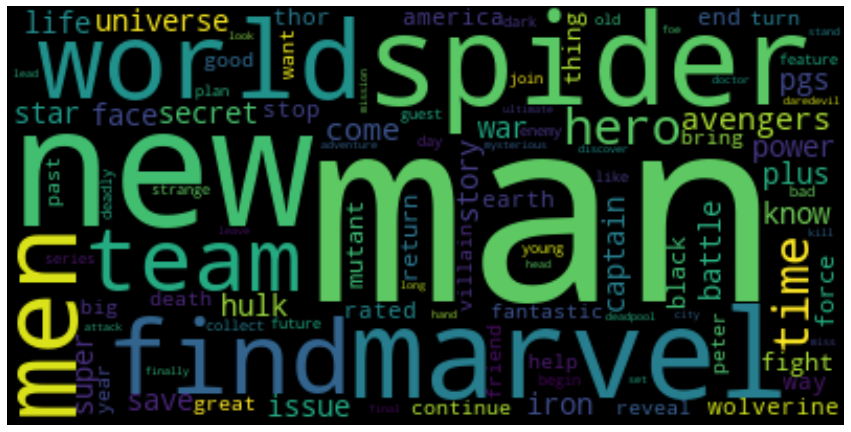

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(marvel_comic_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='black').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Building a dictionary of words
In the next step, we will build a dictionary, in which all unique words will be given identifiers, and their frequencies will be recorded. It is worth noting that we use the gensim library to build the dictionary. In gensim, words are referred to as "tokens," and the index of each word in the dictionary is called ID

In [7]:
from gensim import corpora

#creating a word dictionary
%time dictionary = corpora.Dictionary(marvel_comic_plot)

#list of several words that can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.49 s


Once the dictionary is created, content-neutral words and additional stopwords are removed.

In [8]:
#Printing the top 50 entries from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)


[[['comic', 0], ['folksll', 1], ['fun', 2], ['heart', 3], ['infinite', 4], ['prank', 5], ['talk', 6], ['year', 7], ['attend', 8], ['auction', 9], ['august', 10], ['begin', 11], ['bon', 12], ['bowers', 13], ['brian', 14], ['celebrate', 15], ['chad', 16], ['chris', 17], ['festival', 18], ['fury', 19], ['illegal', 20], ['japan', 21], ['level', 22], ['men', 23], ['nick', 24], ['sims', 25], ['time', 26], ['weapon', 27], ['adventure', 28], ['bank', 29], ['brand', 30], ['calendar', 31], ['comic_strip', 32], ['date', 33], ['favorite', 34], ['february', 35], ['hard', 36], ['hero', 37], ['hit', 38], ['hot', 39], ['join', 40], ['journey', 41], ['luck', 42], ['marvel', 43], ['month', 44], ['new', 45], ['old', 46], ['parker', 47], ['peter', 48], ['punch', 49], ['rob', 50]]]


# Feature Extraction (Bag of Words).
The bag-of-words (BoW) model, is a way of extracting features from text to use them in modeling, such as in machine learning algorithms. It is a representation that describes the occurrence of words in a document. It includes two things

1. a dictionary of known words
2. a measure of the presence of known words.

The doc2bow method iterates through all the words in the text, if the word already exists in the set, it increases the frequency count, otherwise it inserts the word into the set and sets the frequency count to 1.

In [9]:
corpus = [dictionary.doc2bow(desc) for desc in marvel_comic_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)


[[('comic', 1), ('folksll', 1), ('fun', 1), ('heart', 1), ('infinite', 1), ('prank', 1), ('talk', 2), ('year', 1)], [('attend', 1), ('auction', 1), ('august', 1), ('begin', 1), ('bon', 1), ('bowers', 1), ('brian', 1), ('celebrate', 1), ('chad', 1), ('chris', 1), ('festival', 1), ('fury', 1), ('illegal', 1), ('japan', 1), ('level', 1), ('men', 1), ('nick', 1), ('sims', 1), ('time', 1), ('weapon', 1)], [('year', 1), ('time', 1), ('adventure', 2), ('bank', 1), ('brand', 1), ('calendar', 1), ('comic_strip', 1), ('date', 1), ('favorite', 1), ('february', 1), ('hard', 1), ('hero', 1), ('hit', 1), ('hot', 1), ('join', 1), ('journey', 1), ('luck', 1), ('marvel', 1), ('month', 1), ('new', 1), ('old', 1), ('parker', 2), ('peter', 1), ('punch', 1), ('rob', 1), ('romance', 1), ('tale', 1), ('villain', 1), ('vulture', 1)]]


Powyższe wyniki przedstawiają słownictwo wraz z ich częstotliwością.

Construction of the Tf-Idf and LSI model
Tf-Idf or Term frequency-Inverse Document Frequency. This is a commonly used NLP model that helps identify the most important words in each document in a collection. Once the Tf-Idf model is built, it will be passed to the LSI model and the number of features to build will be determined

In [10]:
%time comic_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time comic_lsi_model = gensim.models.LsiModel(comic_tfidf_model[corpus], id2word=dictionary, num_topics=300)

CPU times: user 249 ms, sys: 1 ms, total: 250 ms
Wall time: 249 ms
CPU times: user 41.4 s, sys: 9.78 s, total: 51.1 s
Wall time: 18.9 s


It is a good idea to serialize and store the collection locally so that it can be easily retrieved when needed.

In [11]:
%time gensim.corpora.MmCorpus.serialize('comic_tfidf_model_mm', comic_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('comic_lsi_model_mm',comic_lsi_model[comic_tfidf_model[corpus]])

CPU times: user 4.97 s, sys: 190 ms, total: 5.16 s
Wall time: 5 s
CPU times: user 28.9 s, sys: 629 ms, total: 29.5 s
Wall time: 29.5 s


In [12]:
#Loading the indexed collection
comic_tfidf_corpus = gensim.corpora.MmCorpus('comic_tfidf_model_mm')
comic_lsi_corpus = gensim.corpora.MmCorpus('comic_lsi_model_mm')

print(comic_tfidf_corpus)
print(comic_lsi_corpus)

MmCorpus(34992 documents, 28116 features, 642423 non-zero entries)
MmCorpus(34992 documents, 300 features, 9114900 non-zero entries)


In [13]:
from gensim.similarities import MatrixSimilarity

%time comic_index = MatrixSimilarity(comic_lsi_corpus, num_features = comic_lsi_corpus.num_terms)

CPU times: user 12.5 s, sys: 136 ms, total: 12.6 s
Wall time: 12.7 s


# Semantic search
Having an index of comics initialized and loaded, we can use it to find similar comics

Entering a query, the model will return us the corresponding comic book titles along with "Relevance %", which is the degree of similarity. The higher the similarity score, the more similar the query is to the document in the given index.

Below is a helper function to search the index, sort and return the results

In [14]:
from operator import itemgetter

def search_similar_comics(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = comic_tfidf_model[query_bow]
    query_lsi = comic_lsi_model[query_tfidf]

    comic_index.num_best = 5

    comic_list = comic_index[query_lsi]

    comic_list.sort(key=itemgetter(1), reverse=True)
    comic_names = []

    for j, comic in enumerate(comic_list):

        comic_names.append (
            {
                'Relevance': round((comic[1] * 100),2),
                'Comic Title': df_comics['comic_name'][comic[0]],
                'Comic Plot': df_comics['issue_description'][comic[0]]
            }

        )
        if j == (comic_index.num_best-1):
            break

    return pd.DataFrame(comic_names, columns=['Relevance','Comic Title','Comic Plot'])

In [15]:
#Search for comic book titles, which are associated with the following search parameters
search_similar_comics('Shield')

,Relevance,Comic Title,Comic Plot
0,71.70,Captain America (1998 - 2002),A unique Energy shield replaces Captain Ameeri...
1,52.03,Captain America (1998 - 2002),Captain America's shield is shattered and tras...
2,48.72,Captain America (1968 - 1996),Stane International has Cap's mighty shield! A...
3,46.35,Captain America (1968 - 1996),The Black Panther's got a gift for the new Cap...
4,44.46,Captain America (1968 - 1996),What's Cap doing with Hawkeye's weapons? And w...


In [16]:
#Search for comic book titles, which are associated with the following search parameters
search_similar_comics('God')

,Relevance,Comic Title,Comic Plot
0,99.85,King in Black (2020 - 2021),WHAT'S A GOD TO A NONBELIEVER?
1,94.19,The Mighty Thor (2011 - 2012),"Who is Tanarus, and why is he the new God of T..."
2,89.88,Venus (1948 - 1952),The macho Man-God Apollo possesses hapless Mar...
3,86.17,Thor: God of Thunder (2012 - 2014),Following the bloody wake of murdered gods acr...
4,85.24,Daredevil (1964 - 1998),Mr. Hyde…a god? The man behind the menagerie h...


In [17]:
#Search for comic book titles, which are associated with the following search parameters
search_similar_comics('Wolverine')

,Relevance,Comic Title,Comic Plot
0,86.78,Wolverine (1988 - 2003),Wolverine is tested by the Major and his hench...
1,84.29,Wolverine (2010 - 2012),WOLVERINE GOES TO HELL PART 4 Demonically-poss...
2,84.20,Wolverine & the X-Men (2014),"Happy Birthday, Quentin Quire! Party crasher W..."
3,83.57,Uncanny X-Men (1981 - 2011),Watch as Wolverine is transformed into a Brood!
4,82.53,Wolverine: The Best There Is - Contagion (2011),Collecting WOLVERINE: THE BEST THERE IS #1-3
